# Processing the results of the motif search

In [13]:
import nengo
import multiprocessing
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hashids import Hashids
from run_motif_search import *
import os
import scipy
from tqdm import tqdm
import networkx as nx


## Function defs

In [12]:


def draw_graph(metadata,ax=None):
    mm = metadata[0]
    lr = metadata[1]
    # Create the adjacency matrix
    adj = np.zeros((8,8))
    adj[:4, :4] = mm
    adj[4:, 4:] = mm
    adj[4:,:4] = lr
    adj[:4,4:] = lr
    # Create graph
    G = nx.from_numpy_matrix(adj, create_using=nx.DiGraph)
    # Draw graph
    node_positions = [
        [-2,1], # L1
        [-1,0], # L2
        [-2,-1], # L3
        [-1,-2], # L4
        [2,1], # R1
        [1,0], # R2
        [2,-1], # R3
        [1,-2] # R4
    ]
    labels = {
        0: 'L1',
        1: 'L2',
        2: 'L3',
        3: 'L4',
        4: 'R1',
        5: 'R2',
        6: 'R3',
        7: 'R4'
    }
    nx.draw_networkx(G, pos=node_positions,ax=ax, with_labels=True, labels=labels )
def process_fn(top,fn):
    with open(os.path.join(datapath,fn), 'rb') as fp:
        ret = pickle.load(fp)
    
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    ax = axs[0]
    tslc = slice(1000,None)
    ax.scatter(ret['time'][tslc], ret['motor_values'][tslc], s=0.4)
    params = tuple(top.loc[fn,['a','b','c','d','e']])
    cov = top.loc[fn, 'cov']
    err = top.loc[fn,'err']
    ax.title.set_text("err : {}, params : {}".format(np.round(err,4),np.round(params,2)))
    ax.plot(ret['time'][tslc], sin_fit(np.array(ret['time'][tslc]).ravel(), *params), color='tab:orange')
    ax.legend(['Fit','Data'])
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    ax = axs[1]
    fig.suptitle('Rank {}'.format(top.index.get_loc(fn)))
    draw_graph(ret['_metadata'],ax)

## Data load

In [7]:
raw_df = pd.read_pickle('sin_fit_results_df2_s0.pkl')
datapath = './data'


## Apply filters

In [8]:
# Filter out small amplitude waves -- usually means that there was no output
df = raw_df.copy()
df = df.query("abs(a) >= 1e-2")
# Filter out super low frequency waves -- usually bad fit
df = df.query("b > 2")
len(df)

12688

## Evaluate fitness function on parameters and error

In [9]:
df['fitness'] = df.apply(lambda r: r.err, axis=1)
# df['fitness'] = df.apply(lambda r: r.a, axis=1)
# df['fitness'] = df['err']


In [10]:
fit_sorted = df.sort_values(by='fitness')
top = fit_sorted.head()


## Top performers

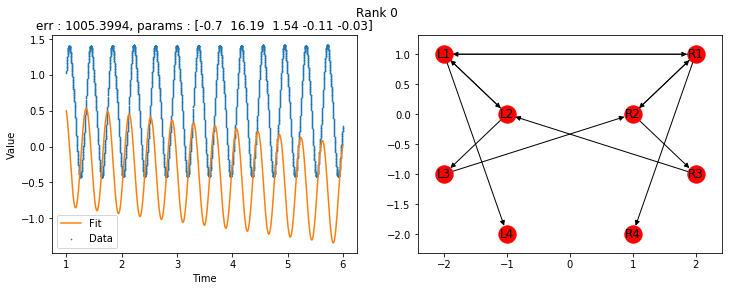

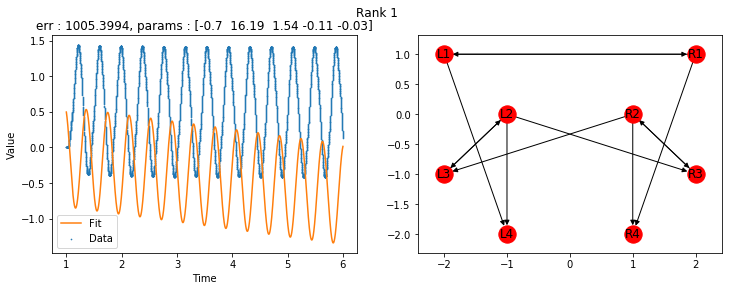

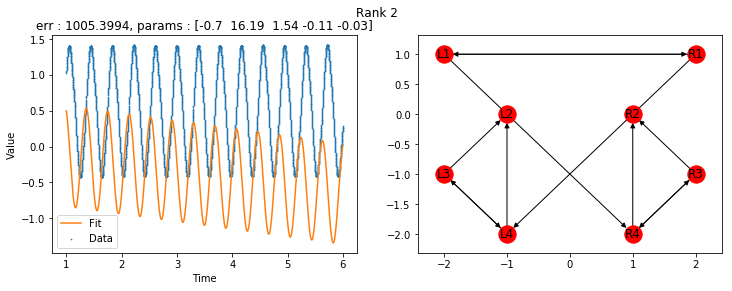

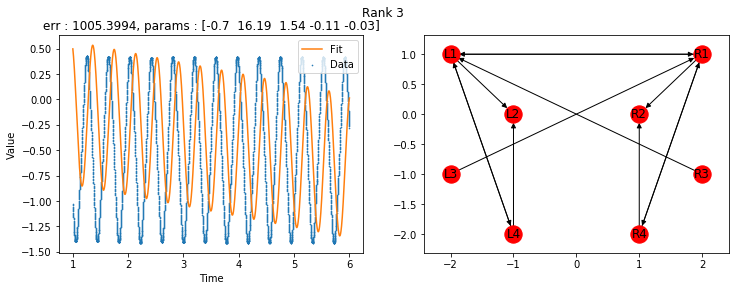

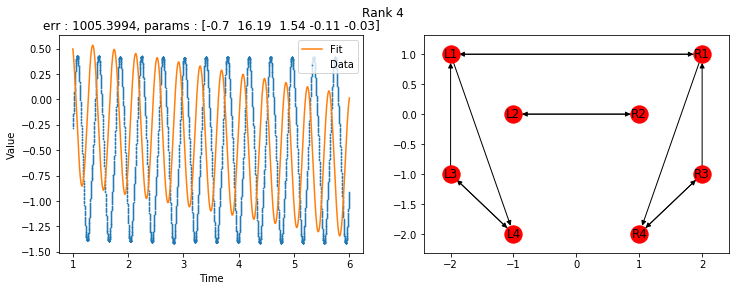

In [11]:
for i,fn in enumerate(top.index):
    process_fn(top,fn)

# Check biological networks

## Leech heartbeat

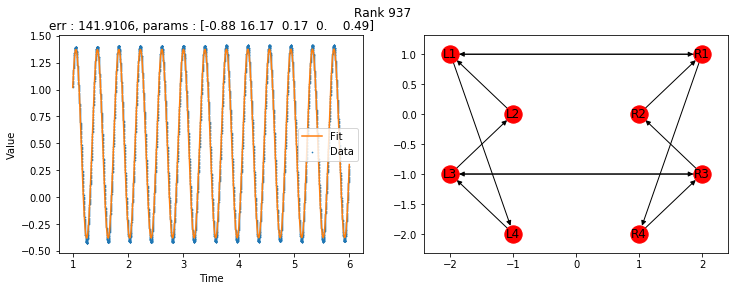

In [28]:
mm = np.array(
[
    [0,0,0,1],
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0]
])
lr = np.array(
[
    [1,0,0,0],
    [0,0,0,0],
    [0,0,1,0],
    [0,0,0,0]
])

fn = make_hash((mm,lr)) + '.pkl'
process_fn(fit_sorted,fn)


## Proposed heartbeat

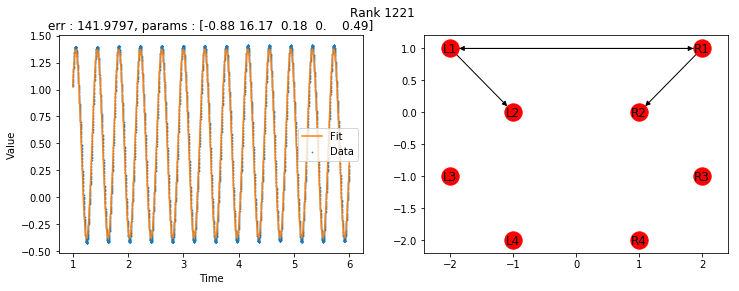

In [31]:
mm = np.array(
[
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])
lr = np.array(
[
    [1,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])

fn = make_hash((mm,lr)) + '.pkl'
process_fn(fit_sorted,fn)

## C. elegans

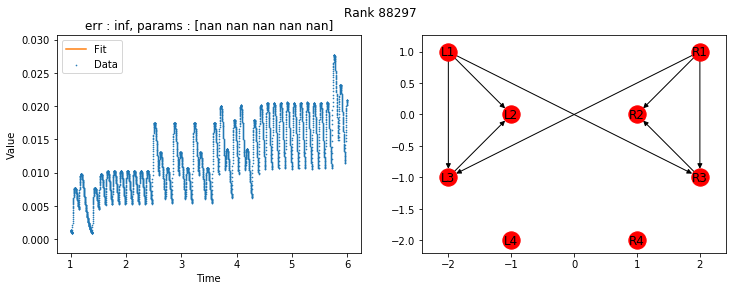

In [39]:
mm = np.array(
[
    [0,1,1,0],
    [0,0,0,0],
    [0,1,0,0],
    [0,0,0,0]
])
lr = np.array(
[
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])

fn = make_hash((mm,lr)) + '.pkl'
process_fn(fit_sorted,fn)

## Check where fitness starts to increase

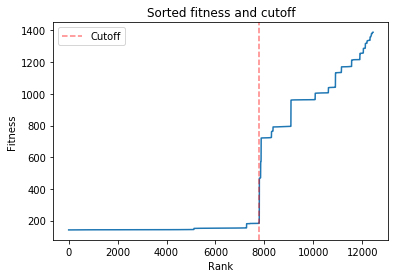

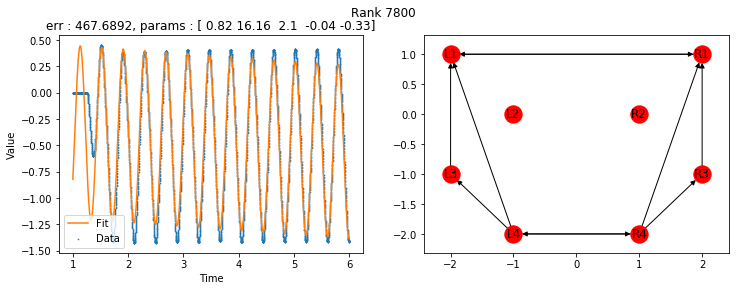

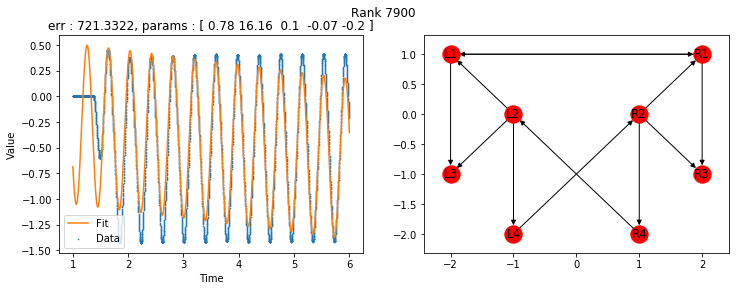

In [37]:
fig, ax = plt.subplots()
ax.plot(fit_sorted['fitness'].to_numpy())
ebreak_idx = 7800
l = ax.axvline(ebreak_idx, ls='--', color='r', alpha=0.5)
ax.set_xlabel('Rank')
ax.set_ylabel('Fitness')
ax.legend([l],['Cutoff'])
ax.title.set_text('Sorted fitness and cutoff')
process_fn(fit_sorted,fit_sorted.iloc[ebreak_idx].name)
process_fn(fit_sorted,fit_sorted.iloc[ebreak_idx+100].name)

In [44]:
top_n = 100
top = fit_sorted.head(top_n)
def add_metadata(idx):
    with open(os.path.join(datapath,idx), 'rb') as fp:
        ret = pickle.load(fp)
    return [ret['_metadata']]
top['_metadata'] = top.index.map(add_metadata)

top.to_pickle('top_sin_fit_{}'.format(top_n))

/home/raph/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [45]:
top

,err,cov,a,b,c,d,e,fitness,_metadata
nQcqcYcqc7clcGcKfYcWcPcGf6f3c8ckckfNcyc2cqc6cxc0cNcBcncnfycNcrcE.pkl,141.15,"[[[4.047541998623909e-07, 4.951706264643733e-0...",0.876707,16.1703,0.172835,-0.000197886,-0.497841,141.149744,"[([[0 0 0 0], [0 0 0 1], [0 0 0 1], [1 0 0 0]]..."
oRcrfZc8c4cQc1fqcDcOcqcnf7fncQcZcgfLc7cocrcpcVc8cAf1crcjcQc7c6cE.pkl,141.15,"[[[4.047541998623909e-07, 4.951706264643733e-0...",0.876707,16.1703,0.172835,-0.000197886,-0.497841,141.149744,"[([[0 1 0 0], [0 0 1 0], [0 0 0 1], [1 0 0 0]]..."
oRcLc1f8cYfQcWcqcDcOcqcXcOc8fxfZcgfLc7cocrcpcVc8cRc1crcjcQcDf6cE.pkl,141.15,"[[[4.047541998623909e-07, 4.951706264643733e-0...",0.876707,16.1703,0.172835,-0.000197886,-0.497841,141.149744,"[([[0 0 1 0], [1 0 0 0], [0 0 0 0], [0 1 1 0]]..."
oRcLcZcqfYfQcWcqcgfOcqcXcOcncxfZcgfLc7cocrcpcVc8cRc1crcjcQc7cnfE.pkl,141.15,"[[[4.0475414293482856e-07, -4.9516859177265105...",-0.876707,16.1703,0.172835,0.000197895,0.497841,141.149745,"[([[0 0 0 1], [1 0 0 0], [1 0 0 0], [0 0 1 0]]..."
oRcLcZcqfYfQcWcqcDcofqcnfOcncQcZcgfLc7cocrcpc1f8cRc1crcjcQc7c6cE.pkl,141.15,"[[[4.0475414293482856e-07, -4.9516859177265105...",-0.876707,16.1703,0.172835,0.000197895,0.497841,141.149745,"[([[0 0 0 1], [1 0 0 0], [0 1 0 1], [0 0 0 0]]..."
nQcqcYcqc7clcZfrc9fWcPc0c6f3c8ckckfNcyc2cqc6cxc0cvfBcnc1cycNcrcE.pkl,141.15,"[[[4.0475414293482856e-07, -4.9516859177265105...",-0.876707,16.1703,0.172835,0.000197895,0.497841,141.149745,"[([[0 0 0 0], [0 0 1 0], [1 0 0 0], [1 0 0 0]]..."
oRcLcZcqfYfQcWcqcgfOcqcXcOcncxfZcgfLc7cocrcpcVcvfRc1crcjcQc7c6cE.pkl,141.15,"[[[4.0475414293482856e-07, -4.9516859177265105...",-0.876707,16.1703,0.172835,0.000197895,0.497841,141.149745,"[([[0 0 0 1], [1 0 0 0], [1 0 0 0], [0 0 1 0]]..."
oRcLcZc8cYfQcWcWfDcofqcXc7fncQcZcgfLc7cocrcpcVc8cRc1cWfjcQc7c6cE.pkl,141.253,"[[[4.0548236267627825e-07, 4.925110340265985e-...",0.87687,16.1738,0.179878,-0.000642276,-0.49601,141.252509,"[([[0 0 0 0], [1 0 0 1], [0 1 0 0], [1 0 0 0]]..."
oRcLcZc8cYfQcWcWfDcofqcXcOc8fQcZcgfLc7cocrcpcVc8cRc1crcjcQc7cnfE.pkl,141.253,"[[[4.0548236267627825e-07, 4.925110340265985e-...",0.87687,16.1738,0.179878,-0.000642276,-0.49601,141.252509,"[([[0 0 0 0], [1 0 0 1], [0 1 0 0], [0 1 0 0]]..."
kQc6cEcnfAcycVcOcqcmc8coczcMcYczcPf4cPcxc1cvczc0c9cmc1cjcEcycDc9.pkl,141.344,"[[[4.045356257102011e-07, -4.938712368662625e-...",-0.876909,16.1717,0.174993,0.000497592,0.496573,141.343559,"[([[0 0 0 1], [0 0 0 0], [0 0 0 0], [0 0 0 0]]..."
